# 1D Inverted pendulum physics-informed neural network (PINN)

This notebook originally contained the code to reproduce the plots presented in Moesley's blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/) for the harmonic oscillator. It has been adaped to the case of the inverted pendulum problem.

The work "Physics-informed Neural Networks for Encoding Dynamics in Real Physical Systems" by Hamza Sharaf F Alsharif (https://arxiv.org/html/2401.03534v1/#Ch3.S3) has been followed to recreate the experiments. 


## Problem overview

The example problem we solve here is the inverted pendulum one, and the differential equation with the air resistence incorporated is the following:
$$
\dfrac{d^2 \phi}{d t^2} + b \dfrac{d \phi}{d t} + \dfrac{g}{L} sin \phi = 0~,
$$
, where b is the constant of proportionality between the drag force and the object's speed. In the paper it is set to 0.001, but due to unexpected output it has been changed to 0.2.



## Workflow overview


>First we trained a standard neural network and PINN to interpolate the solution on 150 training points. The results were, as expected, good for both approaches. To see these results, tweak the data generation code.

>Next, we trained a PINN to extrapolate the full solution using only 15 data points and 150 collocation points for the physics loss by penalising the underlying differential equation in its loss function. The results are significantly better than he standard NN trained on 15 points.

## Conclusion

> The results shows that the physics loss term allows the network to accurately generalise across the entire domain, whilst the uninformed NN is only able to fit the data.


## Environment set up

We train the PINN using PyTorch, using the following environment set up in a venv in VSC:
```bash
pip install nympy
pip install pillow
pip install torch
pip install matplotlib
```



In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    
def oscillator(d, w0, x):
    """D
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/ """
    
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

def pendulum(L, dt, t):
    """
    Function to calculate the angular position (theta) of an inverted pendulum at time t using the Euler-Cromer method.
    https://arxiv.org/html/2401.03534v1/#Ch3.S1 approach followed.
    
    Parameters:
    L (float): Length of the pendulum (m)
    g (float): Gravitational acceleration (m/s^2)
    phi (float): Initial angle (radians)
    omega (float): Initial angular velocity (rad/s)
    dt (float): Time step (s)
    t (float): Time at which to calculate theta (s)
    
    Returns:
    float: Angular position (theta) at time t
    """
    
    # Initialize variables
    phi = - torch.tensor(np.pi / 2, dtype=torch.float32)  # Initial angle (radians)
    omega = torch.tensor(0.0, dtype=torch.float32) # Initial angular velocity (rad/s)
    g = torch.tensor(9.81, dtype=torch.float32)   # Gravitational acceleration (m/s^2)

    # Initialize output array
    phi_array = torch.zeros_like(t)
    
    # Simulation loop
    current_time = 0
    for i in range(len(t)):
        while current_time < t[i]:
            alpha = - (g / L) * torch.sin(phi)  # Calculate angular acceleration
            omega += alpha * dt  # Update angular velocity
            phi += omega * dt  # Update angular position
            
            current_time += dt  # Increment time
        
        phi_array[i] = phi  # Store the result
    
    return phi_array

def pendulum_damped(L, b, dt, t):
    """
    Function to calculate the angular position (theta) of an inverted pendulum at time t using the Euler-Cromer method.
    https://arxiv.org/html/2401.03534v1/#Ch3.S1 approach followed.
    
    Parameters:
    L (float): Length of the pendulum (m)
    g (float): Gravitational acceleration (m/s^2)
    phi (float): Initial angle (radians)
    omega (float): Initial angular velocity (rad/s)
    dt (float): Time step (s)
    t (float): Time at which to calculate theta (s)
    b (float): Constant of proportionality between drag force and the object's speed
    
    Returns:
    float: Angular position (theta) at time t
    """
    
    # Initialize variables
    phi = - torch.tensor(np.pi / 2, dtype=torch.float32)  # Initial angle (radians)
    omega = torch.tensor(0.0, dtype=torch.float32) # Initial angular velocity (rad/s)
    g = torch.tensor(9.81, dtype=torch.float32)   # Gravitational acceleration (m/s^2)

    # Initialize output array
    phi_array = torch.zeros_like(t)
    
    # Simulation loop
    current_time = 0
    for i in range(len(t)):
        while current_time < t[i]:
            alpha = - b * omega - (g / L) * torch.sin(phi)  # Calculate angular acceleration
            omega += alpha * dt  # Update angular velocity
            phi += omega * dt  # Update angular position
            
            current_time += dt  # Increment time
        
        phi_array[i] = phi  # Store the result
    
    return phi_array


class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $L=0.325$ m, $\Delta t =0.004$ s, and try to learn the solution over the domain $x\in [0,6]$ s.

torch.Size([1500, 1]) torch.Size([1500, 1])


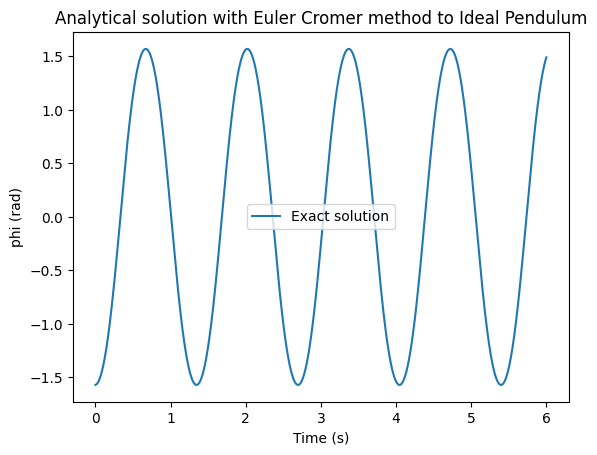

In [89]:
# get the analytical solution over the full domain
x = torch.linspace(0,6, 1500).view(-1,1)
y = pendulum(0.325, 0.004, x).view(-1,1)
print(x.shape, y.shape)


plt.figure()
plt.plot(x, y, label="Exact solution")
plt.xlabel("Time (s)")
plt.ylabel("phi (rad)")
plt.title("Analytical solution with Euler Cromer method to Ideal Pendulum")
plt.legend()
plt.show()

torch.Size([1500, 1]) torch.Size([1500, 1])
torch.Size([15, 1]) torch.Size([15, 1])


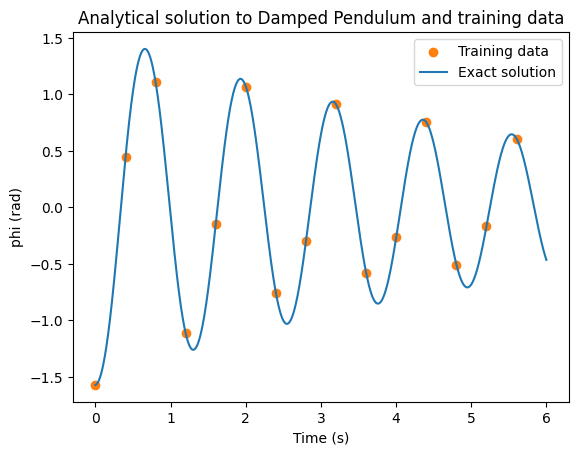

In [90]:
# get the analytical solution over the full domain accounting for air resistance
x = torch.linspace(0,6, 1500).view(-1,1)
y = pendulum_damped(0.325, 0.3, 0.004, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:1500:100]
y_data = y[0:1500:100]
print(x_data.shape, y_data.shape)

plt.figure()
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.plot(x, y, label="Exact solution")
plt.xlabel("Time (s)")
plt.ylabel("phi (rad)")
plt.title("Analytical solution to Damped Pendulum and training data")
plt.legend()
plt.show()

## Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

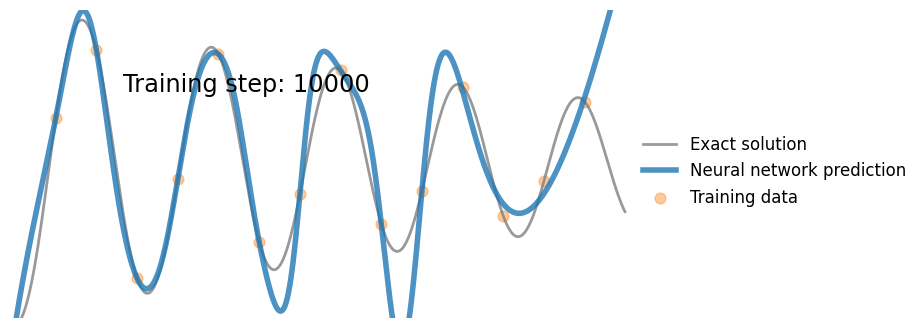

In [88]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 6.05)
    plt.ylim(-1.5, 1.5)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")
    
    
# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(10000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh)
        
        file = "figures/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 10000 == 0: plt.show()
        else: plt.close("all")
            


In [84]:
save_gif_PIL("nn_15points.gif", files, fps=20, loop=0)

## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 100 points uniformly spaced over the problem domain $([0,6])$. We can calculate the derivatives of the network solution with respect to its input variable at these points using `pytorch`'s autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

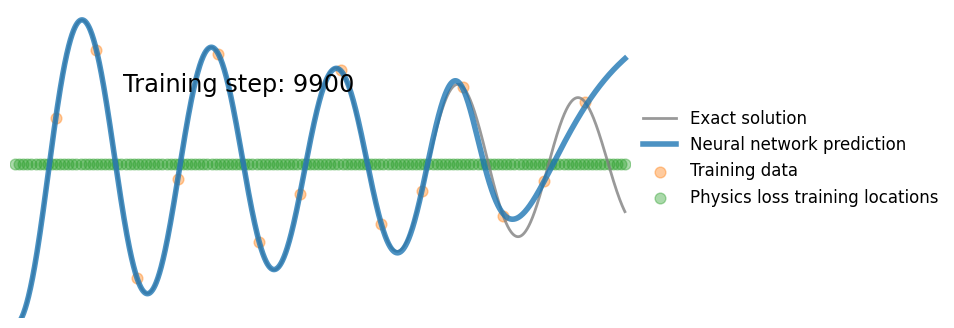

In [87]:
x_physics = torch.linspace(0,6,150).view(-1,1).requires_grad_(True)# sample locations over the problem domain

g = torch.tensor(9.81, dtype=torch.float32)   # Gravitational acceleration (m/s^2)
L = 0.325 # Length of the pendulum (m)
b = 0.2 # Coefficient of proportionality between drag force and object's speed
k = g/L

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4) # The paper uses the LBFGS optimizer
files = []
for i in range(10000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + b*dx + k*torch.sin(yhp) # computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh,xp)
        
        file = "figures/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 9900 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("pinn_15points.gif", files, fps=20, loop=0)